In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import *

In [ ]:
import os
os.chdir('/content/drive/MyDrive/데이콘/exercise_motion_classification/data/')

train=pd.read_csv('train_features.csv')
train_labels=pd.read_csv('train_labels.csv')
test=pd.read_csv('test_features.csv')
submission=pd.read_csv('sample_submission.csv')

In [ ]:
train.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


- train데이터를 id개수별로 맞춰주기 위하여 mean, median, max, min등의 값을 구해서 변수로 추가해보자. 

- 이 방법은 https://dacon.io/competitions/official/235689/codeshare/2306?page=1&dtype=recent&ptype=pub 의 SDSTony님의 코드공유 노트북을 참고하여 진행했습니다. 

In [ ]:
def quantile_75(x):
  return x.quantile(q=0.75)

def quantile_25(x):
  return x.quantile(q=0.25)

features = ['id','acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']
X_train = train[features].groupby('id').agg(['max','min','mean','median','std',quantile_75,quantile_25])
X_test = test[features].groupby('id').agg(['max','min','mean','median','std',quantile_75,quantile_25])

In [ ]:
sns.heatmap(X_train.corr(),cmap='Blues')

In [ ]:
sns.heatmap(X_test.corr(),cmap='Blues')

In [ ]:
y_train = train_labels['label']

In [ ]:
len(y_train.unique())

61

In [ ]:
X_train.shape,y_train.shape

((3125, 42), (3125,))

In [ ]:
X_train.reset_index(inplace=True)
X_train.drop(['id'],axis=1,inplace=True)
X_train

acc_x                      ...        gy_z                        
           max       min      mean  ...         std quantile_75 quantile_25
0     1.344268  0.591940  0.931329  ...   25.275185   19.479614   -9.930266
1     1.234020 -2.156208 -0.766580  ...   75.545343   37.521852  -30.514605
2     1.219836 -1.142847  0.039836  ...   13.920337   10.915188   -4.718664
3    -0.622250 -1.417751 -0.887702  ...   23.647153    7.843401  -19.096905
4     0.599720 -2.429109 -0.659018  ...   46.148326   12.739489   -3.318290
...        ...       ...       ...  ...         ...         ...         ...
3120  0.390798 -1.624711 -0.300454  ...   24.913819    2.601295   -5.959514
3121 -0.446650 -1.575455 -0.974298  ...   12.786464    1.838386   -6.335722
3122  0.744666 -2.578974 -1.114246  ...  131.916609  110.101101 -119.508096
3123  0.915846 -0.929133 -0.111333  ...   71.243150   23.479180  -46.728375
3124  0.538809 -1.013813 -0.434048  ...   49.371117   42.920979  -50.133093

[3125 rows x 42 columns]

In [ ]:
X_test.reset_index(inplace=True)
X_test.drop(['id'],axis=1,inplace=True)
X_test

acc_x                      ...       gy_z                        
          max       min      mean  ...        std quantile_75 quantile_25
0   -0.275446 -1.564000 -1.018731  ...  12.251648    5.104833   -9.483683
1    0.627571 -1.929033 -0.522843  ...  61.604867   29.512729  -43.569149
2    2.972063 -0.792916  0.506947  ...  23.041463   12.942246  -13.266111
3    0.337281 -1.045889 -0.577603  ...  37.967372    8.768108   -9.005791
4    0.015642 -2.153047 -0.738640  ...  43.353007   28.747350  -12.864438
..        ...       ...       ...  ...        ...         ...         ...
777  0.427159 -2.050254 -0.907299  ...  68.462972   29.619127  -25.513229
778  1.659451 -1.709527 -0.608731  ...  81.398849   66.403974  -48.732587
779 -0.085249 -2.124959 -0.753193  ...  48.113344   15.890101  -20.144907
780  1.438345  0.536568  0.958903  ...  26.523530   25.126312  -21.297065
781  0.224194 -1.534616 -0.781752  ...  36.491662    6.547298  -21.046104

[782 rows x 42 columns]

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=572132eed449fbaab6439b838e01f88de722eea0a90da56fbb8d6ce006ec1a82
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
# import BayesianOptimization as bysian_opt
from bayes_opt import BayesianOptimization
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

In [ ]:
def xgb_evaluate(max_depth, gamma,min_child_weight,max_delta_step,subsample,colsample_bytree,lambda_val,learning_rate):
    params = {'eval_metric': 'mlogloss',
              'objective': 'multi:softprob',
              'num_class' : 61,
              'max_depth': int(max_depth),
              'subsample': subsample,
              'eta': learning_rate,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,   
              'min_child_weight': min_child_weight ,
              'max_delta_step':max_delta_step,
              'lambda' : lambda_val
             }
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-mlogloss-mean'].iloc[-1]

In [ ]:
xgb_bo = BayesianOptimization(xgb_evaluate, {
                                    'max_depth': (2, 12),
                                     'gamma': (0.001, 10.0),
                                     'min_child_weight': (0, 20),
                                     'max_delta_step': (0, 10),
                                     'subsample': (0.4, 1.0),
                                     'colsample_bytree' :(0.4, 1.0),
                                     'lambda_val' : (1,5) ,
                                     'learning_rate': (0.01,0.2)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')

|   iter    |  target   | colsam... |   gamma   | lambda... | learni... | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -1.98     |  0.4109   |  8.976    |  1.045    |  0.06181  |  4.661    |  10.07    |  14.5     |  0.7588   |
|  2        | -1.969    |  0.4948   |  8.631    |  3.955    |  0.1844   |  6.318    |  9.757    |  12.74    |  0.6978   |
|  3        | -1.501    |  0.9544   |  2.377    |  4.824    |  0.03204  |  4.177    |  2.177    |  7.118    |  0.9533   |
|  4        | -1.898    |  1.0      |  0.001    |  1.0      |  0.01     |  0.0      |  2.0      |  0.0      |  1.0      |
|  5        | -2.482    |  1.0      |  0.001    |  5.0      |  0.01     |  0.0      |  2.0      |  20.0     |  1.0      |
|  6        | -2.208    |  1.0      |  10.0     |  5.0      |  0.01     |  10.0     |  2.0      |  0.0      |  1.0      |
|  7        | -2.497    

In [ ]:
params = xgb_bo.max['params']

'eval_metric': 'mlogloss',
              'objective': 'multi:softprob',
              'num_class' : 61,

In [ ]:
params['max_depth'] = 2
params['eval_metric'] = 'mlogloss'
params['objective'] = 'multi:softprob'
params['num_class'] = 61

params

{'colsample_bytree': 0.9543751822448909,
 'eval_metric': 'mlogloss',
 'gamma': 2.3765993313084093,
 'lambda_val': 4.823723573634545,
 'learning_rate': 0.0320405651413064,
 'max_delta_step': 4.17743472256279,
 'max_depth': 2,
 'min_child_weight': 7.118213702774423,
 'num_class': 61,
 'objective': 'multi:softprob',
 'subsample': 0.9532572056575737}

In [ ]:
# model = xgb.cv(
#     params=params,
#     dtrain=dtrain,
#     num_boost_round=250,
#     nfold=3,
#     early_stopping_rounds=50,
#     verbose_eval = 50
# )

[0]	train-mlogloss:4.0161+0.000658856	test-mlogloss:4.01991+0.000391357
[50]	train-mlogloss:1.6509+0.0139534	test-mlogloss:1.83764+0.0247386
[100]	train-mlogloss:1.04834+0.00323316	test-mlogloss:1.37089+0.042933
[150]	train-mlogloss:0.773573+0.00116363	test-mlogloss:1.18533+0.0534776
[200]	train-mlogloss:0.664228+0.00402499	test-mlogloss:1.11365+0.0539308
[249]	train-mlogloss:0.630029+0.00527059	test-mlogloss:1.09279+0.053714


In [ ]:
# Fit
final_gb = xgb.train(params, dtrain, num_boost_round=200,verbose_eval=50)

preds = final_gb.predict(dtest)
preds

array([[2.2629129e-03, 1.3735939e-03, 1.4485881e-03, ..., 5.3509131e-02,
        8.9776696e-04, 2.4193702e-03],
       [3.4155915e-03, 1.0963148e-03, 1.0014398e-03, ..., 6.6764903e-04,
        5.7681469e-04, 1.2426766e-03],
       [3.8988949e-03, 3.8244382e-02, 1.3416340e-03, ..., 1.3820825e-03,
        5.5310827e-01, 5.0180196e-03],
       ...,
       [3.2200895e-03, 9.3743415e-04, 8.9762674e-04, ..., 6.5290474e-04,
        5.6760304e-04, 9.0989913e-04],
       [1.4101641e-03, 1.6773954e-02, 5.3884019e-04, ..., 5.4736721e-04,
        2.1532180e-03, 7.3213631e-04],
       [2.3346562e-03, 9.0875855e-04, 1.1368390e-03, ..., 6.5542245e-04,
        5.6321960e-04, 1.8310472e-03]], dtype=float32)

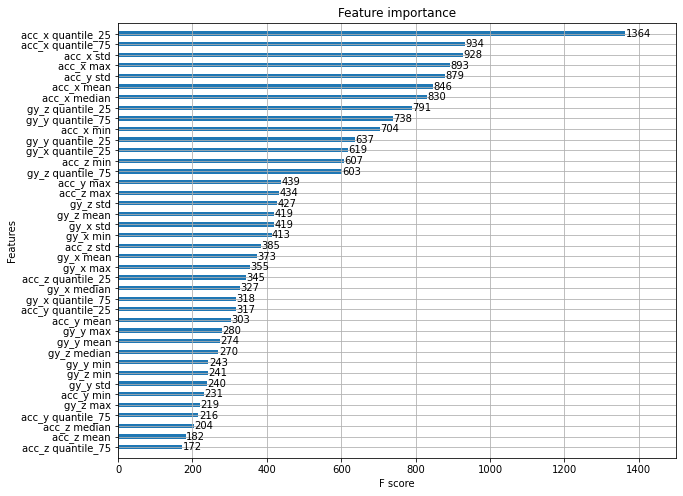

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(final_gb,ax=ax,max_num_features=40,height=0.4)

In [ ]:
submission.iloc[:,1:] = preds
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.002263,0.001374,0.001449,0.001452,0.004862,0.001411,0.001662,0.002144,0.001502,0.042400,0.299209,0.126798,0.002557,0.148962,0.005888,0.003823,0.001244,0.001010,0.001038,0.001021,0.002752,0.001700,0.001428,0.015489,0.115755,0.001014,0.043914,0.001643,0.001009,0.001461,0.004897,0.003620,0.011527,0.001883,0.006483,0.001411,0.006289,0.001438,0.001508,0.001388,0.001453,0.000978,0.003377,0.002043,0.001256,0.002711,0.001274,0.001275,0.004546,0.003282,0.002061,0.024603,0.001617,0.006359,0.002503,0.001433,0.001341,0.002380,0.053509,0.000898,0.002419
1,3126,0.003416,0.001096,0.001001,0.001866,0.001501,0.001125,0.000979,0.002056,0.000962,0.001524,0.001156,0.001085,0.000635,0.000814,0.000748,0.001632,0.001246,0.000634,0.000651,0.000606,0.000786,0.006094,0.001775,0.003611,0.000750,0.000709,0.916168,0.000837,0.000633,0.000744,0.000917,0.000939,0.002406,0.001148,0.008167,0.001586,0.001423,0.000849,0.000740,0.001026,0.001932,0.001413,0.001182,0.001247,0.000752,0.000792,0.000653,0.000869,0.001227,0.001900,0.002121,0.001063,0.000752,0.000786,0.000910,0.000893,0.000964,0.002014,0.000668,0.000577,0.001243
2,3127,0.003899,0.038244,0.001342,0.004845,0.001688,0.002330,0.002730,0.002415,0.003266,0.004146,0.002724,0.001597,0.001307,0.001572,0.002531,0.003216,0.005291,0.007448,0.001257,0.001170,0.001518,0.002310,0.001578,0.002267,0.002325,0.001404,0.184312,0.004769,0.001935,0.002068,0.002125,0.001622,0.006529,0.014876,0.007384,0.003982,0.004603,0.002088,0.002226,0.001982,0.008028,0.009389,0.002912,0.004904,0.004752,0.019244,0.001287,0.001890,0.005569,0.005223,0.003089,0.002161,0.001485,0.002164,0.006387,0.001949,0.012895,0.002239,0.001382,0.553108,0.005018
3,3128,0.007115,0.002106,0.002409,0.001462,0.001455,0.001559,0.001189,0.001503,0.002670,0.001517,0.001177,0.000939,0.001117,0.001122,0.001386,0.003137,0.001028,0.000979,0.001006,0.000936,0.001215,0.005505,0.001205,0.001851,0.001315,0.000982,0.852986,0.000973,0.000978,0.001607,0.001623,0.001231,0.014573,0.001305,0.005210,0.001854,0.003033,0.001258,0.001118,0.001345,0.001218,0.001172,0.004797,0.005697,0.001333,0.001199,0.001729,0.001300,0.002689,0.016440,0.006761,0.001184,0.001139,0.001615,0.002137,0.001501,0.001115,0.003940,0.001007,0.000870,0.004174
4,3129,0.011589,0.000802,0.000786,0.001272,0.002563,0.001013,0.000899,0.001252,0.001126,0.001296,0.000679,0.000917,0.000583,0.001001,0.000763,0.002907,0.001122,0.000843,0.002147,0.000557,0.000722,0.001134,0.014262,0.001173,0.000751,0.000803,0.907432,0.000590,0.000581,0.000617,0.001025,0.000697,0.001970,0.000948,0.005006,0.001002,0.000915,0.000780,0.000912,0.000800,0.001105,0.000657,0.001156,0.000915,0.000707,0.000713,0.000600,0.000798,0.001052,0.001350,0.006517,0.000948,0.000691,0.000697,0.000761,0.000821,0.000806,0.001551,0.000693,0.000517,0.000706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.016951,0.001115,0.000696,0.001340,0.064915,0.001227,0.001056,0.001148,0.001038,0.009577,0.003759,0.011969,0.000715,0.000858,0.000998,0.007229,0.000957,0.001673,0.004851,0.000654,0.001195,0.002615,0.008525,0.001339,0.004748,0.001345,0.772795,0.000961,0.000683,0.000724,0.015516,0.002142,0.002314,0.001243,0.009389,0.001508,0.002341,0.000973,0.000781,0.000939,0.003016,0.000947,0.003563,0.001456,0.000812,0.000837,0.000705,0.000891,0.002047,0.002349,0.002966,0.003195,0.000865,0.002862,0.000829,0.000958,0.000925,0.001436,0.002822,0.000650,0.001067
778,3903,0.007154,0.001494,0.001167,0.002635,0.002103,0.002406,0.001204,0.001308,0.001158,0.003512,0.001228,0.001058,0.000815,0.000892,0.001244,0.008793,0.001823,0.001128,0.001166,0.000745,0.001920,0.001895,0.002531,0.001540,0.002061

In [ ]:
os.chdir('/content/drive/MyDrive/데이콘/exercise_motion_classification/submission/')
submission.to_csv('xgb_model_ver2.csv', index=False)